In [133]:
import sys
sys.path.append("..")
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
from scipy import optimize
from torch.utils.data import DataLoader, Dataset
from data_loaders import *
import missing_process.missing_method as missing_method
from missing_process.block_rules import *
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.rcParams['text.usetex'] = False

In [131]:
real_datalist = ["banknote","concrete_compression",
            "wine_quality_white","wine_quality_red",
            "california","climate_model_crashes",
            "connectionist_bench_sonar","qsar_biodegradation",
            "yeast","yacht_hydrodynamics"
            ]
#real_datalist = ["yacht_hydrodynamics"]

syn_datalist = ["syn1"]


missingtypelist = ["quantile","diffuse","logistic"]
#missingtypelist = ["diffuse"]

In [264]:
def mask_visualization(missingtypelist,datalist_name):
    '''
    create density plot
    '''
    

    if datalist_name == "real":
        datalist = real_datalist
    elif datalist_name == "syn":
        datalist = syn_datalist

    for missingtype in missingtypelist:
        if missingtype == "logistic":
            missing_rule = load_json_file("missing_rate.json")
        elif missingtype == "diffuse":
            missing_rule = load_json_file("diffuse_ratio.json")
        elif missingtype == "quantile":
            missing_rule = load_json_file("quantile_full.json")


        missing_rate_d = {}
        # load data and its mask
        for dataname in datalist:
            directory_path = f"../datasets/{dataname}"    
            norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
            #norm_values = norm_values[:,2:4]
            
            print(dataname)
            missing_rate_d[dataname] = []

            for rule_name in missing_rule:
                
                if rule_name.endswith("1.0"):
                    print(rule_name)

                    rule = missing_rule[rule_name]
                    
                    observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')


                    Xnan, Xz = missing_by_range(norm_values, rule)
                    observed_masks = np.array(~np.isnan(Xnan), dtype=np.float)

                    make_plot(norm_values,observed_masks,title = rule_name)
                    make_single_plot(norm_values,observed_masks,title = rule_name)



        return norm_values,observed_masks

In [268]:
# norm_values,observed_masks = mask_visualization(missingtypelist,"syn")


In [258]:
def make_plot(norm_value,mask, title = None):
        # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    axes = axes.ravel()  # Flatten the 4x2 grid for easy iteration
    masked_value = norm_value * mask
    nan_mask = np.where(mask == 0, np.nan, mask)
    masked_value_na = norm_value * nan_mask
    for i in range(norm_value.shape[1]):
        norm_column = norm_value[:, i]
        mask_column = masked_value[:, i]
        mask_column_na = masked_value_na[:, i]

        bins = np.histogram_bin_edges([norm_column, mask_column], bins='auto')
        #data_column2 = array_list[1][i]
        # Histogram
        #axes[i].hist(data_column, bins=30, alpha=0.7, edgecolor='black',kde = True)
        sns.histplot(data=norm_column, bins=bins, color='blue',alpha = 0.4, ax=axes[i], kde=True, label='Complete Data',
                     hatch="/", 
                     fill=False
                     )
        sns.histplot(data=mask_column_na, bins=bins, color='green',alpha = 0.6, ax=axes[i], kde=True, label='Data After Missing',
                     hatch='...', 
                     fill=False
                     )
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Histogram for Column {i+1}')
        axes[i].legend()

    if title is not None:
        fig.suptitle(title, fontsize=16)
        # Adjust the layout
    plt.tight_layout()
    plt.savefig(f"../plot/{title}.png")
    plt.show()

In [321]:
def make_single_plot(norm_value, mask, title=None,col = 0):
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(8, 6))

    masked_value = norm_value * mask
    nan_mask = np.where(mask == 0, np.nan, mask)
    masked_value_na = norm_value * nan_mask

    # Use only the first column
    norm_column = norm_value[:, col]
    mask_column = masked_value[:, col]
    mask_column_na = masked_value_na[:, col]

    # Calculate bins
    bins = np.histogram_bin_edges([norm_column, mask_column], bins='auto')

    # Create histograms
    sns.histplot(data=norm_column, bins=bins, color='blue', alpha=0.4, ax=ax, kde=True, label='Complete Data',
                 hatch="/", 
                 fill=False
                )
    sns.histplot(data=mask_column_na, bins=bins, color='green', alpha=0.6, ax=ax, kde=True, label='Data After Missing',
                 hatch='...', 
                 fill=False
                )

    # Set labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram for First Column' if title is None else title)
    ax.legend()

    # Adjust the layout and save the plot
    plt.tight_layout()
    # if title is not None:
    #     plt.savefig(f"../plot/Norm_{title}.png")
    plt.show()

## MCAR

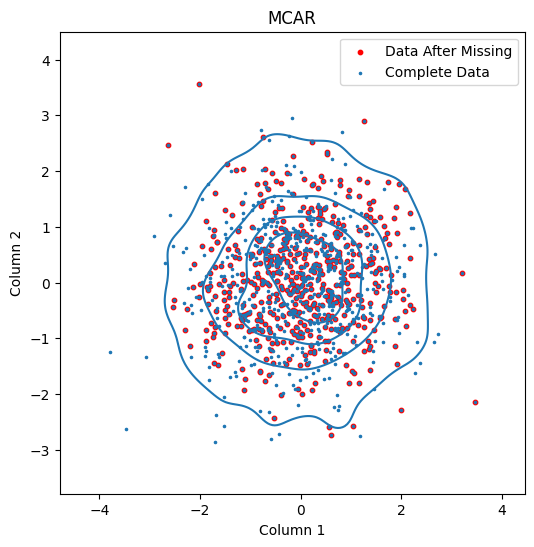

In [121]:
orgin = np.random.randn(1000, 2)
observed_masks = ~np.isnan(orgin.astype("float32"))
masks = observed_masks.copy().astype("float32")

mcar_mask =  MCAR(orgin, 0.5, masks)
nan_mask = np.where(mcar_mask == 0, np.nan, mcar_mask)
masked_value_na_MCAR = orgin * nan_mask
create_contour(masked_value_na_MCAR,orgin,"MCAR")



## MAR

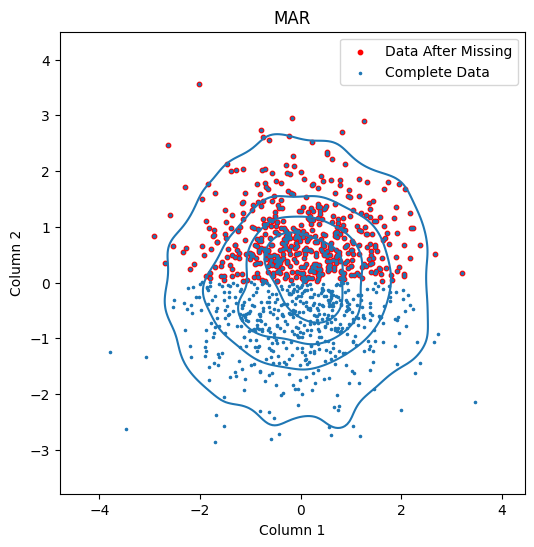

In [122]:
observed_masks = ~np.isnan(orgin.astype("float32"))
masks = observed_masks.copy().astype("float32")

mar_mask = MAR(orgin, masks)
nan_mask = np.where(mar_mask == 0, np.nan, mar_mask)
masked_value_na_MAR = orgin * nan_mask
create_contour(masked_value_na_MAR,orgin,"MAR")

## Focused MNAR

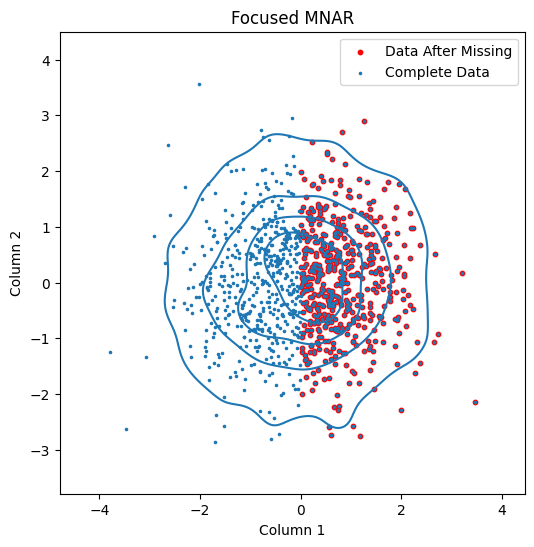

In [123]:
observed_masks = ~np.isnan(orgin.astype("float32"))
masks = observed_masks.copy().astype("float32")

mnar_mask = MNAR(orgin, masks)
nan_mask = np.where(mnar_mask == 0, np.nan, mnar_mask)
masked_value_na_MNAR_f = orgin * nan_mask
create_contour(masked_value_na_MNAR_f,orgin,"Focused MNAR")

## Diffused MNAR

C:\Users\Epochoid\AppData\Local\Temp\ipykernel_29376\1396323940.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  orgin_d = np.random.default_rng().multivariate_normal(mean, cov, 1000)


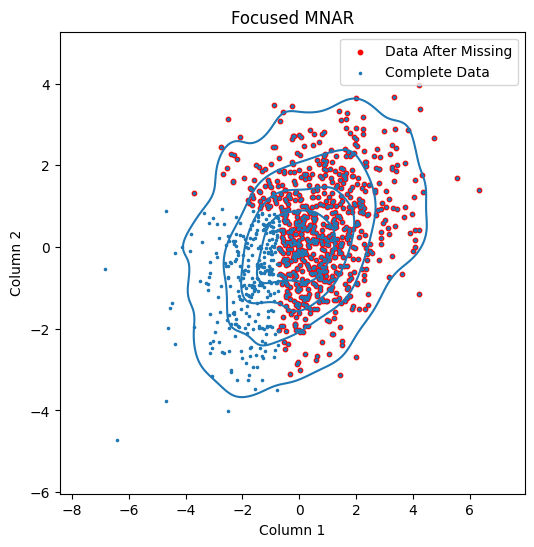

In [124]:
mean = [0, 0]
cov = [[1, 3], [2, 1]]
orgin_d = np.random.default_rng().multivariate_normal(mean, cov, 1000)
observed_masks = ~np.isnan(orgin_d.astype("float32"))
masks = observed_masks.copy().astype("float32")

mnar_d_mask = MNAR_diffuse(orgin_d, masks)
nan_mask = np.where(mnar_d_mask == 0, np.nan, mnar_d_mask)
masked_value_na_MNAR_d = orgin_d * nan_mask
create_contour(masked_value_na_MNAR_d,orgin_d,"Focused MNAR")


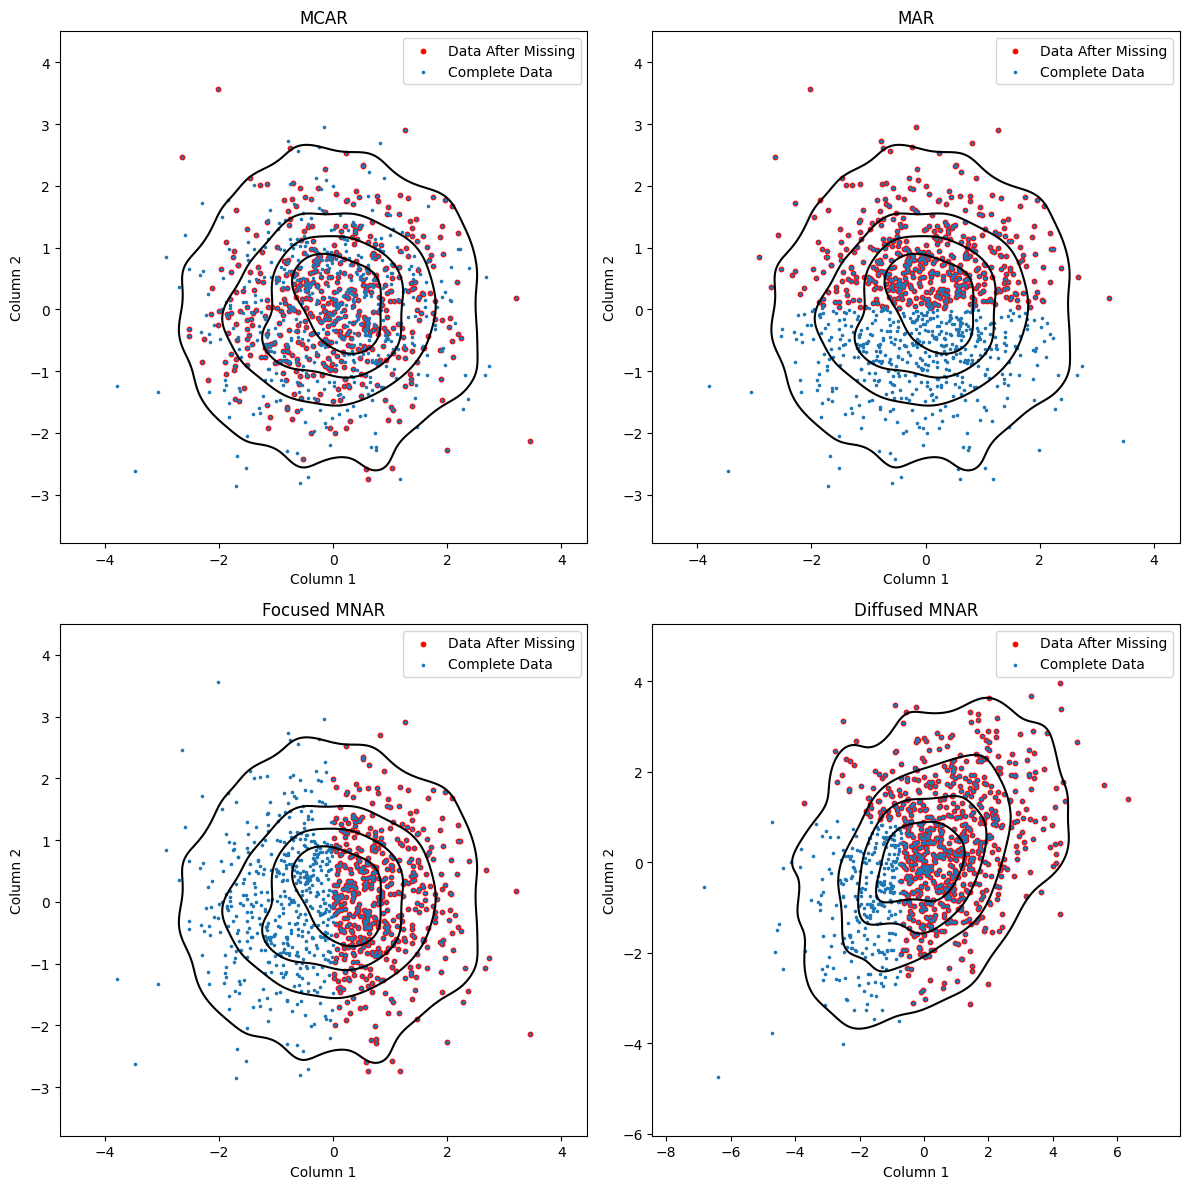

In [129]:
create_contour_list([masked_value_na_MCAR,masked_value_na_MAR,
                     masked_value_na_MNAR_f,masked_value_na_MNAR_d],
                     [orgin,orgin,orgin,orgin_d],
                     ["MCAR","MAR","Focused MNAR","Diffused MNAR"])

In [119]:
def create_contour(masked_value_na,orgin,title):

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter plot
    ax.scatter(masked_value_na[:, 0], masked_value_na[:, 1], s=10,label = "Data After Missing",marker="o",alpha=1, c="red")
    ax.scatter(orgin[:, 0], orgin[:, 1], s=10,label = "Complete Data",marker=".")
    # Density plot with contour lines using Seaborn's kdeplot
    sns.kdeplot(x=orgin[:, 0], y=orgin[:, 1], ax=ax, levels=5, linewidths=1.5)

    # Set titles and labels (these would be based on your specific datasets)
    ax.set_title(f'{title}')
    ax.set_xlabel('Column 1')
    ax.set_ylabel('Column 2')
    ax.legend()

    plt.show()


In [113]:
def MCAR(observed_values, missing_rate, masks):
    """
    Apply Missing Completely at Random (MCAR) to the given data.
    
    Parameters:
    observed_values (np.array): The input data array with shape (n_samples, n_features).
    missing_rate (float): The proportion of data to be marked as missing in each column.
    masks (np.array): An initial mask matrix with the same shape as observed_values,
                      where all values are set to 1.

    Returns:
    np.array: The array with missing data applied.
    np.array: The mask array with 0s indicating missing data.
    """
    # Check if missing_rate is between 0 and 1
    if not 0 <= missing_rate <= 1:
        raise ValueError("Missing rate must be between 0 and 1.")
    
    n_samples, n_features = observed_values.shape
    
    new_mask = masks.copy()
    # Copy observed_values to avoid altering the original data
    data_with_missing = observed_values.copy()
    

    n_missing = int(n_samples * missing_rate)
        
        # Randomly choose indices for 'missing' data
    missing_indices = np.random.choice(n_samples, n_missing, replace=False)
        
        # Set chosen indices to np.nan in the data and 0 in the masks
    new_mask[missing_indices, 0] = 0
    
    return new_mask


def MAR(observed_values, masks):
    """
    Apply Missing at Random (MAR) to the first column of the data based on the second column.

    Parameters:
    observed_values (np.array): The input data array with shape (n_samples, n_features).
    masks (np.array): An initial mask matrix with the same shape as observed_values,
                      where all values are set to 1.

    Returns:
    np.array: The mask array with 0s indicating missing data in the first column.
    """
    if observed_values.shape[1] < 2:
        raise ValueError("The input array must have at least two columns for MAR.")

    n_samples = observed_values.shape[0]
    
    new_mask = masks.copy()

    # Calculate the median of the second column
    med = np.median(observed_values[:, 1])

    # Identify indices where first column's value is larger than the median of the second column
    missing_indices = np.where(observed_values[:, 1] < med)[0]

    # Set these indices to 0 in the mask for the first column
    new_mask[missing_indices, 0] = 0

    return new_mask



def MNAR(observed_values, masks):
    """
    Apply Missing at Random (MAR) to the first column of the data based on the second column.

    Parameters:
    observed_values (np.array): The input data array with shape (n_samples, n_features).
    masks (np.array): An initial mask matrix with the same shape as observed_values,
                      where all values are set to 1.

    Returns:
    np.array: The mask array with 0s indicating missing data in the first column.
    """
    if observed_values.shape[1] < 2:
        raise ValueError("The input array must have at least two columns for MAR.")

    n_samples = observed_values.shape[0]
    
    new_mask = masks.copy()

    # Calculate the median of the second column
    med = np.median(observed_values[:, 0])


    # Identify indices where first column's value is larger than the median of the second column
    missing_indices = np.where(observed_values[:, 0] < 0)[0]

    # Set these indices to 0 in the mask for the first column
    new_mask[missing_indices, 0] = 0

    return new_mask



def MNAR_diffuse(observed_values, masks):
    """
    Apply Missing at Random (MAR) to the first column of the data based on the second column.

    Parameters:
    observed_values (np.array): The input data array with shape (n_samples, n_features).
    masks (np.array): An initial mask matrix with the same shape as observed_values,
                      where all values are set to 1.

    Returns:
    np.array: The mask array with 0s indicating missing data in the first column.
    """
    if observed_values.shape[1] < 2:
        raise ValueError("The input array must have at least two columns for MAR.")

    n_samples = observed_values.shape[0]
    
    new_mask = masks.copy()

    # Calculate the median of the second column
    bound_1 = np.percentile(observed_values[:, 0], 35)
    bound_2 = np.percentile(observed_values[:, 1], 75)

    # Identify indices where first column's value is larger than the median of the second column
    missing_indices = np.where((observed_values[:, 0] < bound_1) & (observed_values[:, 1] < bound_2))[0]

    # Set these indices to 0 in the mask for the first column
    new_mask[missing_indices, 0] = 0

    return new_mask

In [128]:

def create_contour_list(masked_value_na_list, origin_list, titles):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()  # Flatten the axes array for iteration
    
    for i, ax in enumerate(axes):
        # Scatter plot for missing data
        ax.scatter(masked_value_na_list[i][:, 0], masked_value_na_list[i][:, 1], 
                   s=10, label="Data After Missing", marker="o", alpha=1, c="red")
        
        # Scatter plot for complete data
        ax.scatter(origin_list[i][:, 0], origin_list[i][:, 1], 
                   s=10, label="Complete Data", marker=".")
        
        # Density plot with contour lines using Seaborn's kdeplot
        sns.kdeplot(x=origin_list[i][:, 0], y=origin_list[i][:, 1], ax=ax, 
                    levels=5, color="k", linewidths=1.5)

        # Set titles and labels
        ax.set_title(f'{titles[i]}')
        ax.set_xlabel('Column 1')
        ax.set_ylabel('Column 2')
        ax.legend()

    plt.tight_layout()
    plt.savefig(f"../plot/Contour.png")
    plt.show()



## Missing Rate

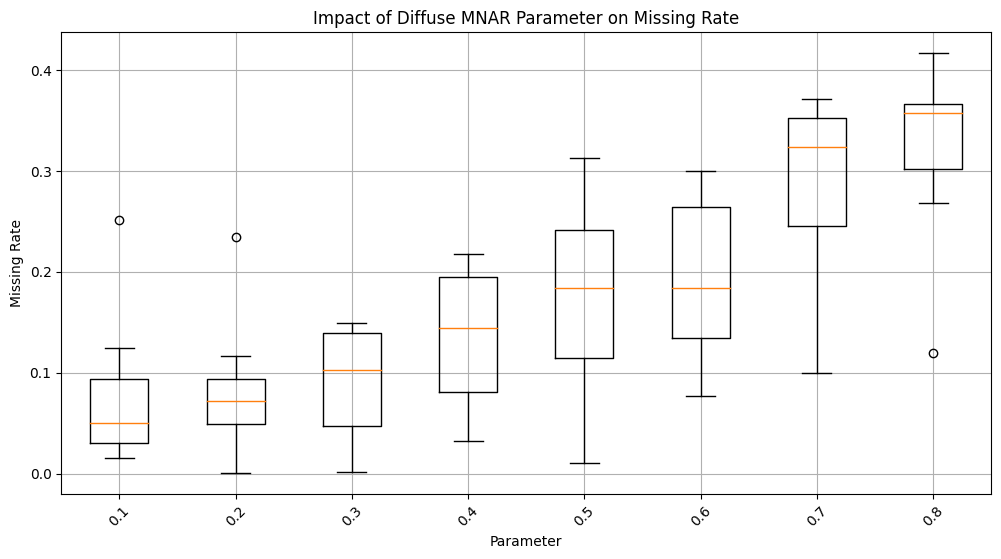

In [151]:
df = pd.read_csv(f"../datasets/real_diffuse_missing_rate.csv", index_col=0).T

plt.figure(figsize=(12, 6))
plt.boxplot(df.values, labels=df.columns, #patch_artist=True
            )
plt.title('Impact of Diffuse MNAR Parameter on Missing Rate')
plt.xlabel('Parameter')
plt.ylabel('Missing Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(f"../plot/Logistic_MissingRate.png")
plt.show()

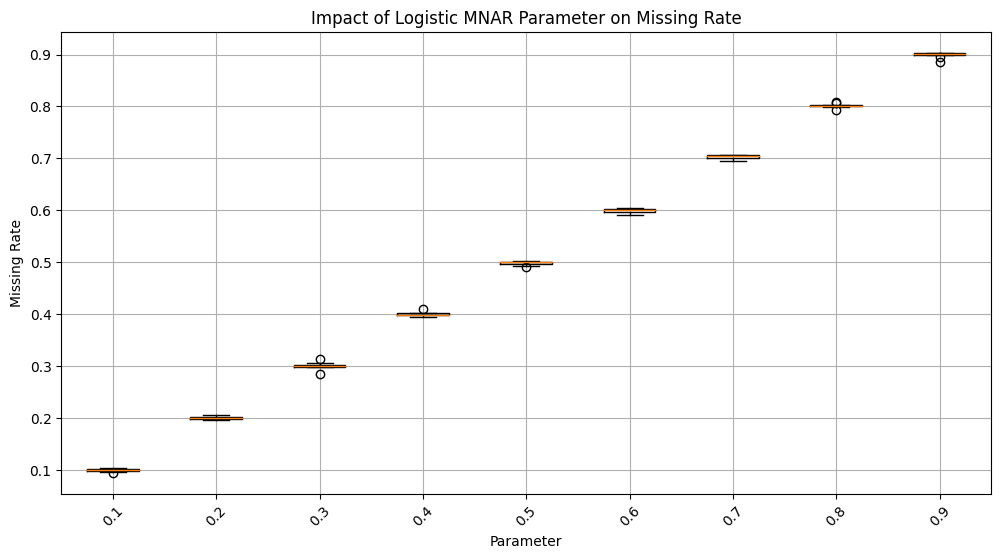

In [150]:
df = pd.read_csv(f"../datasets/real_logistic_missing_rate.csv", index_col=0).T

plt.figure(figsize=(12, 6))
plt.boxplot(df.values, labels=df.columns, #patch_artist=True
            )
plt.title('Impact of Logistic MNAR Parameter on Missing Rate')
plt.xlabel('Parameter')
plt.ylabel('Missing Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(f"../plot/Logistic_MissingRate.png")
plt.show()

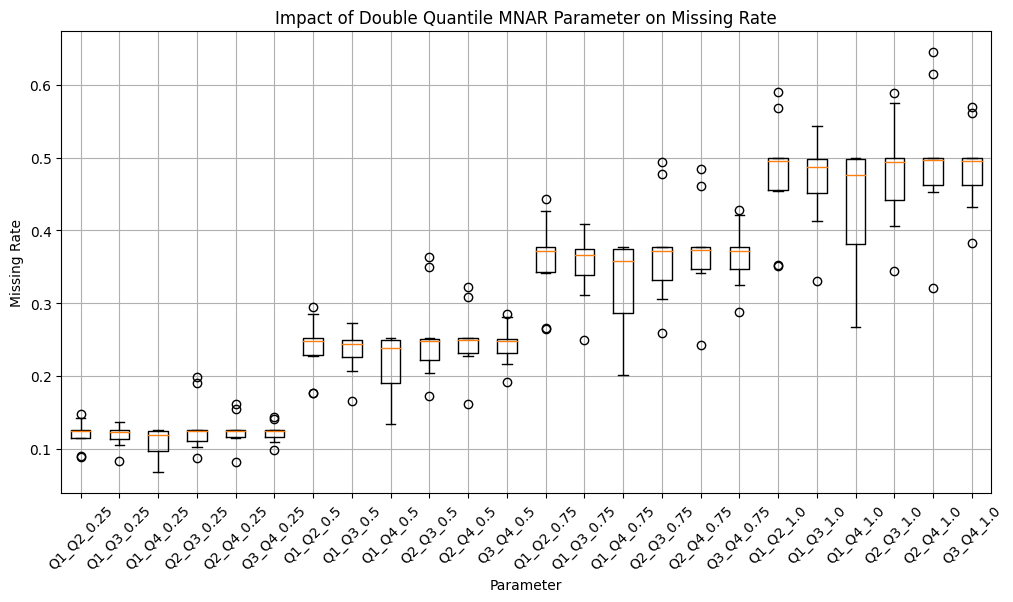

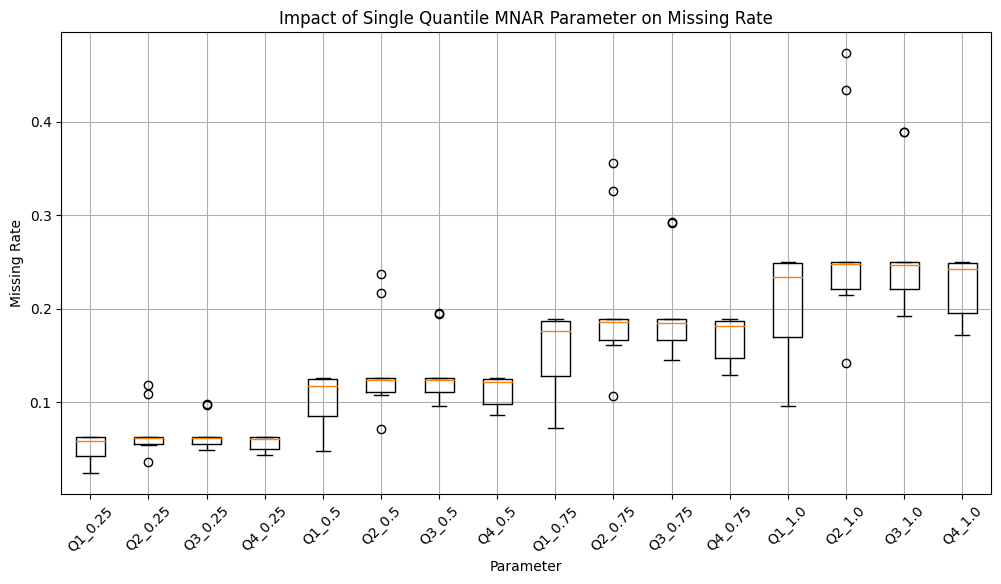

In [166]:
df = pd.read_csv(f"../datasets/real_quantile_missing_rate.csv", index_col=0)

sub_df1 = df[(df.index.str.len() == 9) | (df.index.str.len() == 10)].T  # Length of index is 9
sub_df2 = df[(df.index.str.len() == 7 ) | (df.index.str.len() == 6)].T  # Length of index is 7


plt.figure(figsize=(12, 6))
plt.boxplot(sub_df1.values, labels=sub_df1.columns, #patch_artist=True
            )
plt.title('Impact of Double Quantile MNAR Parameter on Missing Rate')
plt.xlabel('Parameter')
plt.ylabel('Missing Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(f"../plot/DoubleQuantile_MissingRate.png")
plt.show()


plt.figure(figsize=(12, 6))
plt.boxplot(sub_df2.values, labels=sub_df2.columns, #patch_artist=True
            )
plt.title('Impact of Single Quantile MNAR Parameter on Missing Rate')
plt.xlabel('Parameter')
plt.ylabel('Missing Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig(f"../plot/SingleQuantile_MissingRate.png")
plt.show()